<a href="https://colab.research.google.com/github/aepanfilov/shov/blob/work2/Shov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import os
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers, backend
from tensorflow.keras.models import Model, Sequential
# from keras import backend

# Загрузка и распаковка фото

In [2]:
# @title Выбор источника данных {"run":"auto","vertical-output":true,"form-width":"50%","display-mode":"form"}
## @markdown Имя файла/архива с данными
# file_name = "NGF5NGG5.txt" # @param {"type":"string","placeholder":""}
#@markdown Источник загрузки котировок:
load_source = "Архивы с сайта f1065011.xsph.ru" # @param ["Архивы с сайта f1065011.xsph.ru","Архивы в сессионном хранилище (вручную)","Архивы с Гугл Диска"]
#@markdown Загружаемые архивы:
shov_file = True # @param {"type":"boolean","placeholder":"sddsf"}
noshov_sclice_file = True # @param {"type":"boolean","placeholder":"sddsf"}
noshov_file = True # @param {"type":"boolean","placeholder":"sddsf"}
centr_file = True # @param {"type":"boolean","placeholder":"sddsf"}
bok_file = True # @param {"type":"boolean","placeholder":"sddsf"}

Имена файлов-архивов и путей в локальном хранилище

In [3]:
# имена файлов
shov_fname = "shov.zip"
noshov_slice_fname = "noshov2.zip"
noshov_fname = "noshov.zip"
centr_fname = "centr.zip"
bok_fname = "bok.zip"

# пути к папам с извлеченными фото
path_train='/content/train'
path_test='/content/test'

In [4]:
# получение файлов-архивов в сессионное хранилище и настройка путей к ним
if load_source=='Архивы с Гугл Диска':
  from google.colab import drive # Модуль для работы с Google Disk
  drive.mount('/content/drive')
  # использовать '\' для экранирования 'пробела' в пути
  path_on_drive="/content/drive/MyDrive/Colab\ Notebooks/"
  shov_fname=path_on_drive+shov_fname
  noshov_slice_fname=path_on_drive+noshov_slice_fname
  noshov_fname=path_on_drive+noshov_fname
  centr_fname=path_on_drive+centr_fname
  bok_fname=path_on_drive+bok_fname

elif load_source=='Архивы в сессионном хранилище (вручную)':
  shov_fname="/content/"+shov_fname
  noshov_slice_fname="/content/"+noshov_slice_fname
  noshov_fname="/content/"+noshov_fname
  centr_fname="/content/"+centr_fname
  bok_fname="/content/"+bok_fname

elif load_source=='Архивы с сайта f1065011.xsph.ru':
  # загрузка архивов с сайта в рабочую папку 'content\'
  if shov_file:
    !wget http://f1065011.xsph.ru/shov/original/shov.zip     # 31,8M
  if noshov_sclice_file:
    !wget http://f1065011.xsph.ru/shov/noshov2.zip           # 38M
  if noshov_file:
    !wget http://f1065011.xsph.ru/shov/original/noshov.zip;   # 57,8M
  if centr_file:
    !wget http://f1065011.xsph.ru/shov/original/centr.zip    # 15,6M
  if bok_file:
    !wget http://f1065011.xsph.ru/shov/original/bok.zip      # 2,5M

print('shov_fname=',shov_fname)
print('noshov_slice_fname=',noshov_slice_fname)
print('noshov_fname=',noshov_fname)
print('centr_fname=',centr_fname)
print('bok_fname=',bok_fname)

--2025-04-09 10:37:48--  http://f1065011.xsph.ru/shov/original/shov.zip
Resolving f1065011.xsph.ru (f1065011.xsph.ru)... 141.8.192.151
Connecting to f1065011.xsph.ru (f1065011.xsph.ru)|141.8.192.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32606845 (31M) [application/zip]
Saving to: ‘shov.zip’

shov.zip            100%[===================>]  31.10M  7.32MB/s    in 4.3s    

2025-04-09 10:37:53 (7.17 MB/s) - ‘shov.zip’ saved [32606845/32606845]

--2025-04-09 10:37:53--  http://f1065011.xsph.ru/shov/noshov2.zip
Resolving f1065011.xsph.ru (f1065011.xsph.ru)... 141.8.192.151
Connecting to f1065011.xsph.ru (f1065011.xsph.ru)|141.8.192.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39309363 (37M) [application/zip]
Saving to: ‘noshov2.zip’

noshov2.zip         100%[===================>]  37.49M  7.90MB/s    in 4.7s    

2025-04-09 10:37:58 (7.90 MB/s) - ‘noshov2.zip’ saved [39309363/39309363]

--2025-04-09 10:37:58--  http://f10650

In [5]:
# распаковка из архивов (qq=без протокола, u=только новые, d=выходной путь)
if noshov_sclice_file:
  !unzip -qq -u $noshov_slice_fname -d $path_train
if centr_file:
  !unzip -qq -u $centr_fname -d $path_train
#if bok_file:
 # !unzip -qq -u $bok_fname -d $path_train

if shov_file:
  !unzip -qq -u $shov_fname -d $path_test
if noshov_file:
  !unzip -qq -u $noshov_fname -d $path_test

In [ ]:
# очистка/удаление папки (при необходимости)
# !rm -r '/content/train/bok'
# !rm -r '/content/train'
# !rm -r '/content/test'

In [6]:
data_dir = pathlib.Path(path_train).with_suffix('')
data_dir

PosixPath('/content/train')

In [7]:
test_dir = pathlib.Path(path_test).with_suffix('')
test_dir

PosixPath('/content/test')

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'В датасете для обучения {image_count} изображений')
image_count2 = len(list(test_dir.glob('*/*.jpg')))
print(f'В датасете для проверки {image_count2} изображений')

В датасете для обучения 10954 изображений
В датасете для проверки 2777 изображений


# Разделение фото на выборки

In [9]:
batch_size = 32
img_height = 100
img_width = 100
# датасет для обучения
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10954 files belonging to 2 classes.
Using 8764 files for training.


In [10]:
# вывод списка классов
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['centr', 'noshov']


Пример изображения

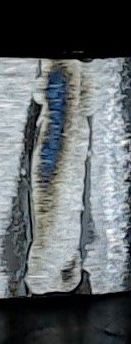

In [11]:
# selected_class = 'shov'
selected_class = 'centr'
selected_imgs = list(data_dir.glob(f'{selected_class}/*'))
PIL.Image.open(str(selected_imgs[5]))

In [12]:
# датасет для проверки
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10954 files belonging to 2 classes.
Using 2190 files for validation.


Просмотр примеров фото

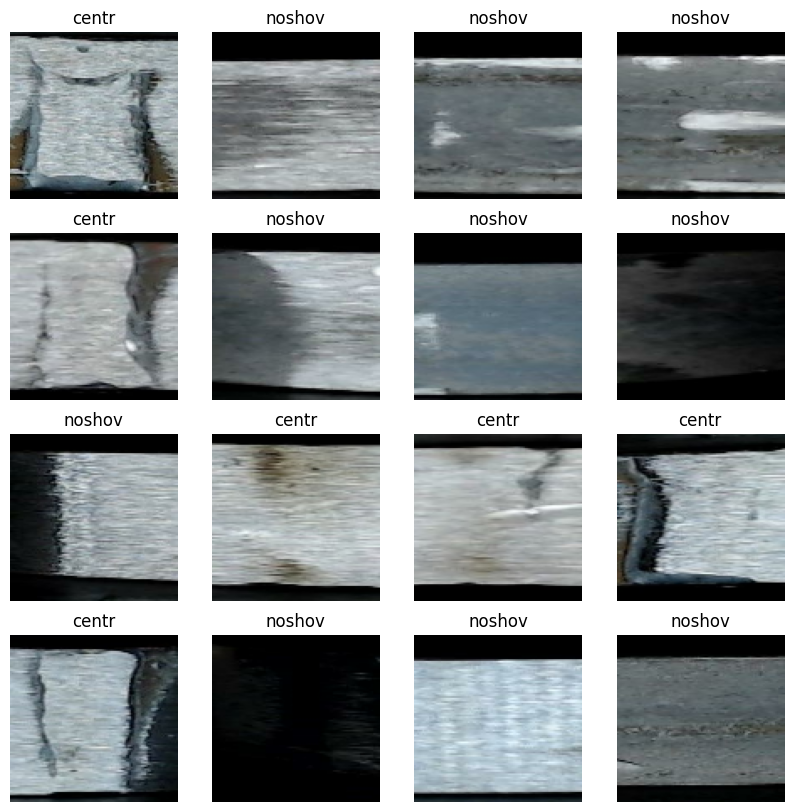

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
	for i in range(16):
		ax = plt.subplot(4, 4, i + 1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(class_names[labels[i]])
		plt.axis("off")

In [14]:
#для кеширования изображений, чтобы они не подгружались в начале каждой эпохи обучения
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Задание и обучение нейронной сети

In [27]:
# @title Выполнить загрузку обученной НС из файла? {"run":"auto","vertical-output":true,"display-mode":"form"}
loading_model = True # @param {"type":"boolean"}

In [25]:
#имя файла НС модели
model_file="model_shov.keras"

In [28]:
if loading_model:
  # проверить наличие файла в локальном хранилище
  full_model_file=os.path.join('/content',model_file)
  if not os.path.isfile(full_model_file):
    model_url=os.path.join('http://f1065011.xsph.ru/shov',model_file)
    !wget $model_url
    print('НС загружена из файла')
  else:
    print('файл НС уже в файловом хранилище')
  model = tf.keras.models.load_model(model_file)
else:
  backend.clear_session()
  model = Sequential()
  model.add(layers.Input(shape=(img_height, img_width, 3)))
  model.add(layers.Rescaling(1./255))
  model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(num_classes))
  #сборка модели
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

--2025-04-09 10:42:24--  http://f1065011.xsph.ru/shov/model_shov.keras
Resolving f1065011.xsph.ru (f1065011.xsph.ru)... 141.8.192.151
Connecting to f1065011.xsph.ru (f1065011.xsph.ru)|141.8.192.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14491130 (14M)
Saving to: ‘model_shov.keras’

model_shov.keras    100%[===================>]  13.82M  9.51MB/s    in 1.5s    

2025-04-09 10:42:25 (9.51 MB/s) - ‘model_shov.keras’ saved [14491130/14491130]

НС загружена из файла


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,610,856 (13.77 MB)

 Trainable params: 1,203,618 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,407,238 (9.18 MB)

In [30]:
# обучение НС
if not loading_model:
  epochs=3
  history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Результаты обучения НС

In [31]:
if not loading_model:
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Точность обучения')
  plt.plot(epochs_range, val_acc, label='Точность на проверочных')
  plt.legend(loc='lower right')
  plt.title('Точность')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Потери на обучающих')
  plt.plot(epochs_range, val_loss, label='Потери на проверочных')
  plt.legend(loc='upper right')
  plt.title('Потери')
  plt.show()

## Проверка на отдельном фото

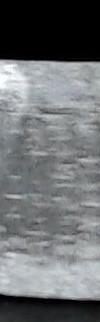

In [32]:
# selected_class = 'centr'
selected_class = 'noshov'
test_img = list(data_dir.glob(f'{selected_class}/*'))[35]
PIL.Image.open(str(test_img))

In [33]:
img = tf.keras.utils.load_img(test_img, target_size=(img_height, img_width))
#получить массив пикселей
img_array = tf.keras.utils.img_to_array(img) #Image в np.array [H, W, 3]
img_array = tf.expand_dims(img_array, 0) # np.array расширить до тензора [1, H, W, 3]
#получение прогноза
predictions = model.predict(img_array, verbose='no')
score = tf.nn.softmax(predictions[0])
max_ind=np.argmax(score)
print("класс '{}' с вероятностью {:.2f} %".format(class_names[max_ind], 100 * score[max_ind]))
display(pd.DataFrame({'cls':class_names,'sc':score}))

класс 'noshov' с вероятностью 99.99 %


,cls,sc
0,centr,0.000054
1,noshov,0.999946


## Расширение выборки (закомментировано)

In [ ]:
# data_augmentation = keras.Sequential(
#   [
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1)
#   ]
# )

In [ ]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

In [ ]:
# backend.clear_session()
# model = Sequential([
#   data_augmentation,
#   layers.Rescaling(1./255),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, name="outputs")
# ])

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
# epochs = 10
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Точность обучения')
# plt.plot(epochs_range, val_acc, label='Точность на проверочных')
# plt.legend(loc='lower right')
# plt.title('Точность')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Потери на обучающих')
# plt.plot(epochs_range, val_loss, label='Потери на проверочных')
# plt.legend(loc='upper right')
# plt.title('Потери')
# plt.show()

In [ ]:
# PIL.Image.open(str(test_img))

## Сохранение модели в файл

In [34]:
if not loading_model:
  model.save("model_shov.keras")
  print('НС сохранена в файл')

# Проверка НС на широких фото

## Используемые функции

In [35]:
from PIL.Image import Resampling

# Нарезать фото (image) на части шириной (sub_width) с шагом (stride)
def slice_image(image, sub_width, stride):
  SUB_HEIGHT=img.height
  sub_imagesH=[]
  sub_images=[]
  sub_count=1+(image.width-sub_width)//stride
  for x in range(sub_count):
    sub_imagesH.append(image.crop((x*stride, 0, x*stride + sub_width, SUB_HEIGHT)))
    sub_images.append(image.resize((img_height, img_width),
                                   resample= Resampling.BILINEAR,
                                   box=(x*stride, 0, x*stride + sub_width, SUB_HEIGHT)))
  return (sub_images, sub_imagesH)

In [36]:
# вывод картинок с заголовками в 1 ряд
def show_images(subs, titles, fontsize=10):
  count_subs=len(subs)
  plt.figure(figsize=(12, 4))
  for i in range(count_subs):
    axs = plt.subplot(1, count_subs,i+1)
    plt.imshow(subs[i])
    plt.title(titles[i],fontsize=fontsize)
    plt.axis("off")

  fig, ax = plt.subplots(figsize=(12, 2))
  plt.plot(100*sub_score.numpy())
  plt.title('Вероятность шва от номера сегмента фото');
  xticks = np.arange(0, sub_count, 1)
  ax.set_xticks(xticks)
  # yticks = np.arange(0, 100, 5)
  # ylabels = [f'{x:1.0f}%' for x in yticks]
  # ax.set_yticks(yticks, labels=ylabels)

  plt.show()
  plt.close()

In [65]:
def selectImage():
  selected_class = 'shov'
  # selected_class = 'noshov'
  num_sample = 21
  path_test_img = list(test_dir.glob(f'{selected_class}/*'))[num_sample]
  img = PIL.Image.open(str(path_test_img))
  print('Fото выбрано',img.size)
  display(img)
  return img

## Параметры нарезки фото

In [37]:
SUB_WIDTH = 100   # ширина сегмента фото
stride = 50       # шаг сдвига сегмента фото

## Проверка на одном фото

### Загрузка фото и нарезка на части

размер фото (500, 303)


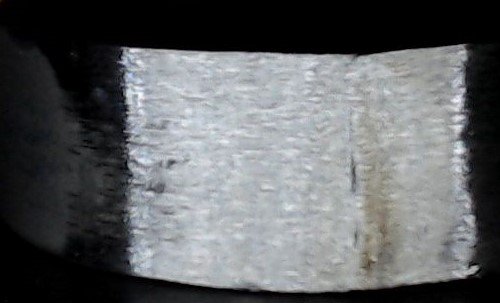

In [58]:
selected_class = 'shov'
# selected_class = 'noshov'
num_sample = 21
path_test_img = list(test_dir.glob(f'{selected_class}/*'))[num_sample]
img=PIL.Image.open(str(path_test_img))
print('размер фото',img.size)
img

Fото выбрано (500, 303)


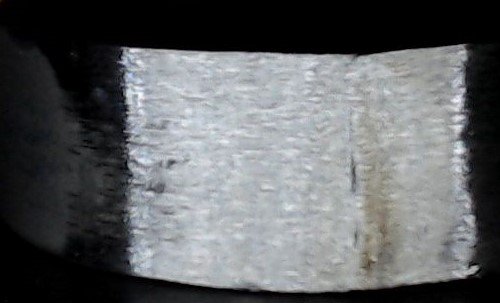

In [66]:
img = selectImage()

Нарезать фото на части

(100, 100)


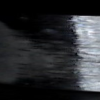

(100, 303)


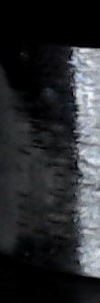

In [39]:
sub_images,sub_imagesH = slice_image(img, SUB_WIDTH, stride)
sub_count=len(sub_images)

num_sample_img =1
print(sub_images[0].size)
display(sub_images[num_sample_img])
print(sub_imagesH[0].size)
display(sub_imagesH[num_sample_img])

### Прогноз на нарезанных фото

макс. вероятность шва на фото=1.7%


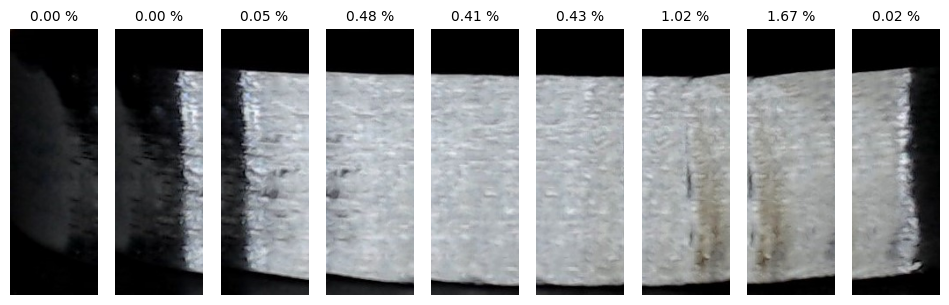

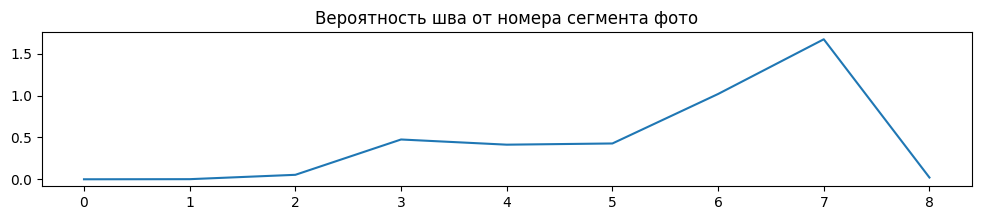

In [40]:
sub_tf=[keras.utils.img_to_array(sub_images[i]) for i in range(sub_count)]

# прогноз НС по отдельным частям фото
predictions = model.predict_on_batch(tf.convert_to_tensor(sub_tf))
score = tf.nn.softmax(predictions)
# print('вероятности по классам\n',score)
ind_centr=np.where(np.array(class_names)=='centr')[0][0]
sub_score=score[:,ind_centr]
print(f'макс. вероятность шва на фото={max(sub_score.numpy())*100:3.1f}%')
# print('вероятность шва на фото\n',sub_score)

tit_sc=["{:.2f} %".format(100*x) for x in sub_score]
show_images(sub_imagesH, tit_sc)#, fontsize=4)

## Проверка на нескольких фото

In [41]:
def predict_image(image):
  sub_tf=[keras.utils.img_to_array(sub_images[i]) for i in range(sub_count)]

  # прогноз НС по отдельным частям фото
  predictions = model.predict_on_batch(tf.convert_to_tensor(sub_tf))
  score = tf.nn.softmax(predictions)
  # print('вероятности по классам\n',score)
  ind_centr=np.where(np.array(class_names)=='centr')[0][0]
  sub_score=score[:,ind_centr]
  print(f'макс. вероятность шва на фото={max(sub_score.numpy())*100:3.1f}%')
  # print('вероятность шва на фото\n',sub_score)

  tit_sc=["{:.2f} %".format(100*x) for x in sub_score]
  show_images(sub_imagesH, tit_sc)#, fontsize=4)

In [42]:
# import os
# cnt=0
# for a in os.walk(os.path.join(test_dir,'shov')):
#   if cnt==3:
#     break
#   print(cnt,a)
#   cnt+=1

cnt=0
for a in test_dir.glob('shov/*'):
  if cnt==3:
    break
  print(cnt,a)
  cnt+=1

0 /content/test/shov/520.jpg
1 /content/test/shov/542.jpg
2 /content/test/shov/127.jpg


In [43]:
x = list(test_dir.glob(f'{selected_class}/*'))

In [44]:
len(x)

767